<a href="https://colab.research.google.com/github/cb-314/vendor_challenge/blob/main/vendor_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic assumtions and simplifications

* assumptions towards the target
  * given the variables of the task I'm assuming that it's a regression task and not a good/bad product classification task
  * from a business perspective it might be more relevant to classify hits and flops
* preprocessing
  * To make my life easier I will remove everything but [a-zA-Z] and whitespaces, which is very restrictive
  * I will do the same preprocessing for test and train as I don't use the target. In general this is not advisable, but for experimentation purposes I'm taking the risk of informations leaks, which seems low from what I am doing.
* nlp specifics
  * I'm also using a word embedding model and a regression model seperately, which should both be assessed for performance.
  * I jumped straight to word2vec instead of trying bag-of-words or tf/idf or something like that because I don't have a good intuition, which might work better and I didn't want to spend the time to try them out as it would have added a lot of dimension to tuning. So for now this is clamped.
* models
  * For now I will ignore the order of words in text and description as I have limited time
  * I'm not going to attempt to use a Transformer for this task as it would take too much time and ressources
  * I will asses performance only on english items as per my preprocessing, else calculating metrics gets annonying
* general
  * this is more a data story and not some software engineering project at this stage, so I'm not using a proper pipeline and so on yet

# setting everything up

## libraries, constants, etc.

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.decomposition
import sklearn.manifold
import sklearn.linear_model
import sklearn.ensemble

from sklearn.experimental import enable_hist_gradient_boosting
import sklearn.ensemble

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import nltk
import gensim

This should later be put into: requirements installations (in separate requirements file)

In [2]:
# Punkt sentence tokenizer
nltk.download("punkt")
# Word List Corpus
nltk.download("words")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## read data


In [3]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# read parquet file
products_all_raw_df = pd.read_parquet("/content/drive/MyDrive/Data Science/products.parquet.gz")
products_all_raw_df

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,0,0,w21z6tu,Cheese Tofu,None,116
1,1,1,w21z74d,Naughty & Nice - Slice,Chocolate - Slice,30
2,2,2,w21xxgu,301. Pork Dumpling with Hot Chilli Vinaigrette...,"6 Pcs, spicy",25
3,3,3,w23b4u1,Mee Kuah,Contain minced mutton meat,45
4,4,4,w21ztq4,Ham & Cheese Sandwich Set,"Toasted to perfection, this sandwich hits all ...",24
...,...,...,...,...,...,...
633143,633143,701,w21zkpm,Sriracha Chicken Whole Wheat Pita,None,22
633144,633144,17,w23b5j9,Dettol Liquid Hand wash Sensitive 250ml,â€¢ Dettol Liquid Hand Wash kills 99.9% of ger...,22
633145,633145,4135,w21ztw0,Red Bean,4 Pcs,22
633146,633146,3121,w21z6vc,Twister Meal,"Choice of 1 Twister, 1 Hash Brown and choice o...",22


# sanity checks

## check primary keys

In [5]:
test_cols = ["product_id", "vendor_id", "vendor_geohash", "order_count"]
print("all", ":", len(products_all_raw_df))
for i in np.arange(len(test_cols)):
  curr_cols = test_cols[:i+1]
  print(curr_cols, ":", len(products_all_raw_df[curr_cols].drop_duplicates()))

all : 633148
['product_id'] : 633148
['product_id', 'vendor_id'] : 633148
['product_id', 'vendor_id', 'vendor_geohash'] : 633148
['product_id', 'vendor_id', 'vendor_geohash', 'order_count'] : 633148


Nice, these are all unique and we are not being fooled!

## look at target

In [6]:
products_all_raw_df["order_count"].describe()

count    633148.000000
mean          9.482963
std          24.025783
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max        1386.000000
Name: order_count, dtype: float64

In [7]:
products_all_raw_df.nlargest(20, "order_count")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
3845,3845,903,w21zs0h,2pc Chickenjoy VM,"2pc Chickenjoy, 1 Side, 1 Drink, 1 Gravy",1386
18078,18078,19,w23b4j4,Chew's Fresh Brown Eggs with Vitamin E 10s x 60g,,1358
21402,21402,19,w23b4j4,Chew's Corn and Soya Fresh Brown Eggs with Vit...,,1277
45838,45838,1421,w21zwre,Chicken Coney Dog with Beef Sauce Combo,"1 Chicken Coney Dog with Beef Sauce, 1 Reg Cur...",1206
3739,3739,36,w21zey6,Anchor Strong Pilsner Beer Can 490ml,With its long standing European heritage and b...,1196
36414,36414,106,w21z6cf,Fresh Banana 5s,Country of Origin: Philippines,1037
22908,22908,1760,w21zg1k,2 pcs Golden Aroma® Chicken Combo,"2 pieces Golden Aroma® Chicken,1 Reg Curly Fri...",996
51321,51321,1421,w21zwre,Mozza Burger® Combo,"1 Mozza Burger® , 1 Reg Curly Fries & 1 Reg A&...",978
44013,44013,1421,w21zwre,2 pcs Golden Aroma® Chicken Combo,"2 pieces Golden Aroma® Chicken,1 Reg Curly Fri...",961
2976,2976,1421,w21zwre,Double Cheeseburger Combo,"1 Double Cheeseburger, 1 Reg Curly Fries & 1 R...",955


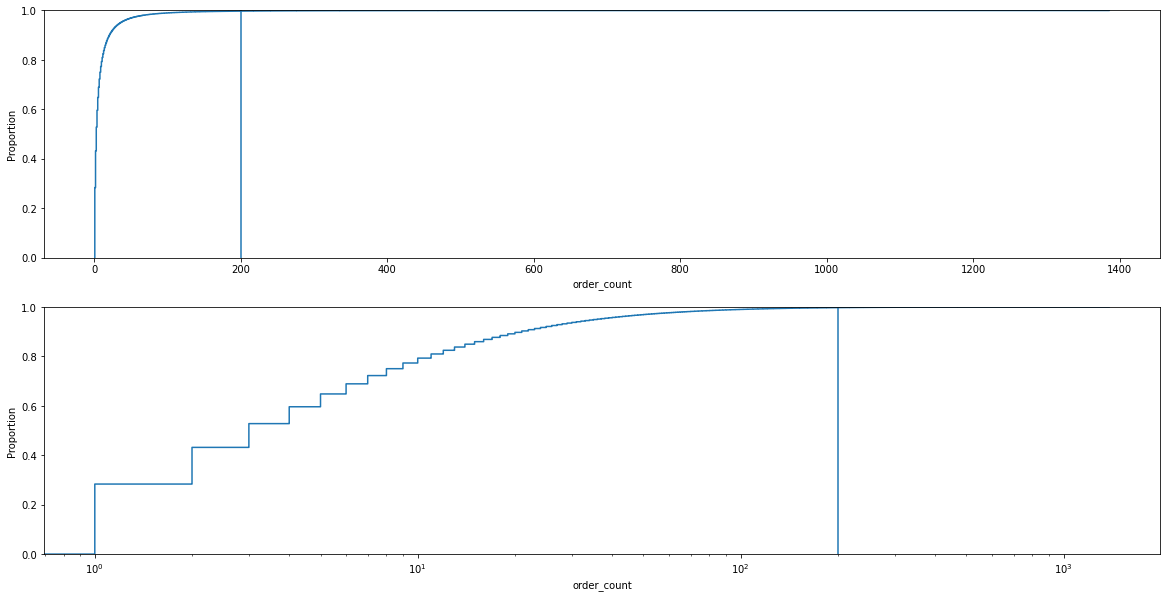

In [8]:
# plot the order count ecdf
fig, ax = plt.subplots(2, 1, figsize = (20, 10))
sns.ecdfplot(
    data=products_all_raw_df,
    x="order_count",
    ax=ax[0]
)
ax[0].axvline(200)
sns.ecdfplot(
    data=products_all_raw_df,
    x="order_count",
    ax=ax[1]
)
ax[1].set_xscale("log")
ax[1].axvline(200)
plt.show()

That is a target distribution I don't really want to see. Most orders are less than five and only a few orders have a significant number. One needs to sample from more than just one month to make useful predictions.

I could apply some transform to order_count, probably log and then clip at 200 or something like that. But this has to be taken into account when calculating MSE/MAE and so on.

# data cleanup

## train test split
For simplicity, I will do the same preprocessing to test and train, which is usually something you have to be really careful doing. However, I'm doing it here for simplicity and because none of the preprocessing steps is using the target.

In [9]:
# sample data for testing
products_sample_raw_df = products_all_raw_df.copy() #sample(20000)

In [10]:
# train test split
products_sample_raw_train_df, products_sample_raw_test_df = sklearn.model_selection.train_test_split(products_sample_raw_df, test_size=0.2)
products_sample_raw_train_df = products_sample_raw_train_df.copy()
products_sample_raw_test_df = products_sample_raw_test_df.copy()
products_sample_raw_train_df["split"] = "train"
products_sample_raw_test_df["split"] = "test"

# put it together for ease of preprocessing
products_sample_raw_train_test_df = pd.concat([products_sample_raw_train_df, products_sample_raw_test_df])
products_sample_raw_train_test_df

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,split
432454,432454,484,w23b4u5,Cereal Milk,None,4,train
410462,410462,3629,w21zeh4,Ninja Chicken Upsized Meal,"Nanban sauce glazed Chicken thigh, shredded wh...",4,train
266221,266221,454,w21zv97,Taiwanese Wine Chicken 台式风味三杯鸡,"A classic Taiwanese dish, using three main ing...",2,train
273282,273282,10831,w21ze00,Squid Ink Nero Di Sepia Pasta,"Squid ink spaghetti with fresh calamari squid,...",2,train
563301,563301,36,w21zey6,New Moon Premium Oyster Sauce 510g,New Moon Oyster Sauce is made with select oyst...,11,train
...,...,...,...,...,...,...,...
226266,226266,592,w21z7rk,Nescafe,None,1,test
74721,74721,6180,w21zute,Samurai Beef SGL Meal + McSpicy Meal (L Fries),Tuck into Samurai Beef Meal and McSpicy® Meal....,1,test
265454,265454,6862,w21ze0z,Spinach with Olive,"Spinach, olives, caramelized onions, feta chee...",2,test
95467,95467,10474,w21zkpm,Coffee Walnut Roll Cake,None,1,test


## data normalization

In [11]:
# use these keys to normalize
primary_keys = ["product_id", "vendor_id", "vendor_geohash", "split"]
text_keys = primary_keys + ["source"]

In [12]:
# split into a more normalized form
products_raw_df = products_sample_raw_train_test_df[primary_keys + ["order_count"]].copy()
products_name_raw_df = products_sample_raw_train_test_df[primary_keys + ["product_name"]].copy().rename({"product_name": "text"}, axis=1)
products_description_raw_df = products_sample_raw_train_test_df[primary_keys + ["product_description"]].copy().rename({"product_description": "text"}, axis=1)

In [13]:
products_df = products_raw_df.copy()
products_name_df = products_name_raw_df.copy()
products_description_df = products_description_raw_df.copy()

In [14]:
# put it together for ease of preprocessing
products_name_df["source"] = "name"
products_description_df["source"] = "description"
products_text_df = pd.concat([products_name_df, products_description_df])

In [15]:
products_text_df

,product_id,vendor_id,vendor_geohash,split,text,source
432454,432454,484,w23b4u5,train,Cereal Milk,name
410462,410462,3629,w21zeh4,train,Ninja Chicken Upsized Meal,name
266221,266221,454,w21zv97,train,Taiwanese Wine Chicken 台式风味三杯鸡,name
273282,273282,10831,w21ze00,train,Squid Ink Nero Di Sepia Pasta,name
563301,563301,36,w21zey6,train,New Moon Premium Oyster Sauce 510g,name
...,...,...,...,...,...,...
226266,226266,592,w21z7rk,test,None,description
74721,74721,6180,w21zute,test,Tuck into Samurai Beef Meal and McSpicy® Meal....,description
265454,265454,6862,w21ze0z,test,"Spinach, olives, caramelized onions, feta chee...",description
95467,95467,10474,w21zkpm,test,None,description


## basic cleanup

In [16]:
# drop empty text
products_text_df.dropna(inplace=True)

# replace everything but basic chars for now
products_text_df["text"].replace("[^a-zA-Z ]", " ", inplace=True, regex=True)

# remove single and double characters
products_text_df["text"].replace("(^| ).( |$)", " ", inplace=True, regex=True)

# remove all double whitespaces
products_text_df["text"].replace("[ ]+", " ", inplace=True, regex=True)

# drop empty text
products_text_df["text"].replace("^[ ]+$", "", inplace=True, regex=True)
products_text_df = products_text_df[products_text_df["text"] != ""]

In [17]:
# sanity check
"".join(sorted(set("".join(["".join(set(x)) for x in products_text_df["text"].tolist()]))))

' ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

In [18]:
# we are still dealing with slices, so copy to be safe
products_text_df = products_text_df.copy()

# to lower
products_text_df["text"] = products_text_df["text"].str.lower()

In [19]:
products_text_df

,product_id,vendor_id,vendor_geohash,split,text,source
432454,432454,484,w23b4u5,train,cereal milk,name
410462,410462,3629,w21zeh4,train,ninja chicken upsized meal,name
266221,266221,454,w21zv97,train,taiwanese wine chicken,name
273282,273282,10831,w21ze00,train,squid ink nero di sepia pasta,name
563301,563301,36,w21zey6,train,new moon premium oyster sauce,name
...,...,...,...,...,...,...
119956,119956,4694,w21z4qn,test,spicy iconic favourite made for singapore since,description
572093,572093,45,w21z7z3,test,home made butter cookies,description
512042,512042,412,w21zkmk,test,eggplant omelette,description
74721,74721,6180,w21zute,test,tuck into samurai beef meal and mcspicy meal m...,description


## tokenization and stemming

In [20]:
products_text_token_df = products_text_df.copy()

In [21]:
# tokenization
products_text_token_df["text_tokens"] = products_text_token_df["text"].transform(nltk.word_tokenize)

In [22]:
# add a position index and explode
products_text_token_df["idx"] = 1
products_text_token_df = products_text_token_df.explode("text_tokens")
products_text_token_df["idx"] = products_text_token_df.groupby(primary_keys)["idx"].cumsum()

In [ ]:
# stemming which we will need later for word2vec
snowball = nltk.stem.SnowballStemmer(language="english")
products_text_token_df["text_tokens_stemmed"] = products_text_token_df["text_tokens"].apply(lambda x: snowball.stem(x))

# filter english items

The general idea here is to count the number of english and total words in name and description and to use this in some way to filter english items.

## checking if tokens are english and couting etc.

In [ ]:
# check if text_tokens are in words corpus
words = nltk.corpus.words.words()
products_text_token_df["is_english"] = products_text_token_df["text_tokens"].isin(words)

In [ ]:
# count english words and total words and add it back to all items
products_english_df = pd.merge(
    products_text_token_df.groupby(text_keys)["is_english"].sum().reset_index().rename({"is_english": "n_english"}, axis=1),
    products_text_token_df.groupby(text_keys)["is_english"].size().reset_index().rename({"is_english": "n_words"}, axis=1),
    on=text_keys,
    how="outer"
  )

# pivot and fill na with 0 as we are dealing with counts
products_english_df = products_english_df.pivot(index = primary_keys, columns="source", values=["n_english", "n_words"])
products_english_df = products_english_df.fillna(0)

# concat column names
products_english_df.columns = [('{0}_{1}'.format(*tup)) for tup in products_english_df.columns]

# reset index
products_english_df = products_english_df.reset_index()

In [ ]:
# calculate the actual frequency = score
products_english_df["n_english_total"] = products_english_df["n_english_description"] + products_english_df["n_english_name"]
products_english_df["n_words_total"] = products_english_df["n_words_description"] + products_english_df["n_words_name"]
products_english_df["english_score"] = products_english_df["n_english_total"] / products_english_df["n_words_total"]

In [ ]:
# drop ones with no english score
products_english_df = products_english_df[~products_english_df["english_score"].isna()]

## filter metric exploration

In [ ]:
# plot the english score ecdf
fig, ax = plt.subplots(1, 1, figsize=(16,6))
sns.ecdfplot(
    data=products_english_df,
    x="english_score",
    ax=ax
)
plt.show()

In [ ]:
# plot the english score as a function of english words
fig, ax = plt.subplots(2, 1, figsize=(16,12))
sns.scatterplot(
    data=products_english_df,
    x="n_english_total",
    y="english_score",
    ax=ax[0]
)
ax[0].set_xlim(0, 100)

sns.boxenplot(
    data=products_english_df,
    x="n_english_total",
    y="english_score",
    ax=ax[1]
)
ax[1].set_xlim(0, 100)

plt.show()

In [ ]:
# original text in score window
products_sample_raw_train_test_df.merge(products_english_df[(products_english_df["english_score"] > 0.2) & (products_english_df["english_score"] < 0.3)][primary_keys], on=primary_keys, how="inner")

In [ ]:
# original text in score window
products_sample_raw_train_test_df.merge(products_english_df[(products_english_df["english_score"] > 0.6) & (products_english_df["english_score"] < 0.7)][primary_keys], on=primary_keys, how="inner")

## look at original text with number of english words

In [ ]:
products_sample_raw_train_test_df.merge(products_english_df[products_english_df["n_english_total"] == 0 ][primary_keys], on=primary_keys, how="inner")

In [ ]:
products_sample_raw_train_test_df.merge(products_english_df[products_english_df["n_english_total"] == 1][primary_keys], on=primary_keys, how="inner")

In [ ]:
products_sample_raw_train_test_df.merge(products_english_df[products_english_df["n_english_total"] == 2][primary_keys], on=primary_keys, how="inner")

In [ ]:
products_sample_raw_train_test_df.merge(products_english_df[products_english_df["n_english_total"] == 3][primary_keys], on=primary_keys, how="inner")

Looks like the english score is not yet good enough. I'll stick for now to "at least one english word", which is also the easiest option. This can always be improved at a later stage.

## actual filtering for english items

In [ ]:
products_english_filtered_df = products_english_df.copy()
products_english_filtered_df = products_english_filtered_df[products_english_filtered_df["n_english_total"] > 0]

In [ ]:
# how much did we filter?
len(products_sample_raw_train_test_df), len(products_english_filtered_df)

# cleanup verdict
Obviously I could improve our cleanup and subsequent filtering by a lot.

* better character level cleaning
* better dictionary (also include more culinary terms like croissant, alfredo, pepsi, some basic chinese dishes, etc.)
* english filtering is now only done by number of english words, but other metrics could be better (like and improved version of the english score I tried)

For now it seems to be good enough.

# word2vec embedding
I will throw name and description together for the word2vec embedding as I will be averaging the vectors anyway. This is not a very good idea, and doc2vec and so on are better alternatives, but for now I stick to KISS and choose the simplest approach.

I train the word2vec only on the training data but already apply it to both training and test data for ease of use. This should prevent information leaks.

In [ ]:
doc_keys = primary_keys + ["order_count"]

## gather data

In [ ]:
products_doc_df = (
    # start with english products
    products_english_filtered_df[primary_keys]
    # add order_count
    .merge(products_df, on=primary_keys, how="inner")
    # add tokens
    .merge(products_text_token_df, on=primary_keys, how="inner")
    # and merge stemmed tokens into list as word2vec needs it
    .groupby(doc_keys)["text_tokens_stemmed"]
    .agg(list)
    .reset_index())

## train embedding

I will ignore hyperparameter tuning of Word2Vec for now. But I'm using CBOW, mainly for speed.

In [ ]:
# train word2vec embedding on training data
w2v_model = gensim.models.Word2Vec(products_doc_df[products_doc_df["split"] == "train"]["text_tokens_stemmed"], sg=0, size=100)

In [ ]:
# calculate tsne for name embedding

# get data
vectors = np.asarray(w2v_model.wv.vectors)

# first reduce dimensionality with pca
pca = sklearn.decomposition.PCA(n_components=50)
vectors_pca = pca.fit_transform(vectors)

# for testing: sample some vectors
#v_idx = np.random.randint(vectors_pca.shape[0], size=1000)
#vectors_pca = vectors_pca[v_idx,:]

# then calculcate tsne
tsne = sklearn.manifold.TSNE(n_components=2, verbose=1, perplexity=20, n_iter=1000)
vectors_tsne = tsne.fit_transform(vectors_pca)

# then add labels for plotting
vectors_df = pd.DataFrame(vectors_tsne, columns=["x", "y"])
vectors_df["label"] = np.asarray(w2v_model.wv.index2entity)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 11891 samples in 0.134s...
[t-SNE] Computed neighbors for 11891 samples in 16.078s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11891
[t-SNE] Computed conditional probabilities for sample 2000 / 11891
[t-SNE] Computed conditional probabilities for sample 3000 / 11891
[t-SNE] Computed conditional probabilities for sample 4000 / 11891
[t-SNE] Computed conditional probabilities for sample 5000 / 11891
[t-SNE] Computed conditional probabilities for sample 6000 / 11891
[t-SNE] Computed conditional probabilities for sample 7000 / 11891
[t-SNE] Computed conditional probabilities for sample 8000 / 11891
[t-SNE] Computed conditional probabilities for sample 9000 / 11891
[t-SNE] Computed conditional probabilities for sample 10000 / 11891
[t-SNE] Computed conditional probabilities for sample 11000 / 11891
[t-SNE] Computed conditional probabilities for sample 11891 / 11891
[t-SNE] Mean sigma: 0.247715
[t-SNE] KL divergenc

In [ ]:
# visualize tsne
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.scatterplot(
    data=vectors_df,
    x="x",
    y="y",
    ax=ax
)
for index, row in vectors_df.sample(200).iterrows():
  plt.annotate(
      s=row["label"],
      xy=(row["x"], row["y"])
  )
plt.show()

Some clustering seems to be there, but I'm not a huge fan of t-SNE as it easily leads to false assumptions. However, it looks good.

## calculate the data embedding

In [ ]:
def embed_tokens(tokens, model):
  dims = model.wv["foo"].shape[0]
  vec = np.zeros(dims)
  if type(tokens) is list and len(tokens) > 0:
    vecs = [model.wv[token] for token in tokens if token in model.wv.vocab.keys()]
    if len(vecs) > 0:
      vec = vec + np.mean(vecs, axis=0)
  return vec

In [ ]:
products_doc_df["text_vec"] = products_doc_df["text_tokens_stemmed"].apply(lambda x: embed_tokens(x, w2v_model))

In [ ]:
products_doc_df

In [ ]:
# look at the doc embeddings for training data
# if you look at the test data, you will become biased, so don't peek
products_doc_plot_df = products_doc_df[products_doc_df["split"] == "train"].sample(1000)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
# tsne with same parameters as above
tsne = sklearn.manifold.TSNE(n_components=2, verbose=1, perplexity=20, n_iter=1000)
vectors = tsne.fit_transform(np.vstack(products_doc_plot_df["text_vec"].to_numpy()))

vectors_df = pd.DataFrame(vectors, columns=["x", "y"])
# clipping and log-scale order-count for plotting
# take care: we dropped the index, so we can't just re-join old data
vectors_df["order_count"] = products_doc_plot_df["order_count"].apply(lambda x: np.log10(np.clip(x, 0, 200))).tolist()

sns.scatterplot(
    data=vectors_df,
    x="x",
    y="y",
    hue="order_count",
    palette="flare_r",
    ax=ax
)
ax.set_title("train")
plt.show()

I don't see anything on this plot and hyperparameter tuning for t-SNE didn't help much.

# Regression

I'm not using pre-built sklearn metrics during exploration because I want to be able to look at error distributions and so on.

## prepare data for learning

In [ ]:
x_train = np.vstack(products_doc_df[products_doc_df["split"] == "train"]["text_vec"])
x_test = np.vstack(products_doc_df[products_doc_df["split"] == "test"]["text_vec"])
y_train = products_doc_df[products_doc_df["split"] == "train"]["order_count"].to_numpy()
y_test = products_doc_df[products_doc_df["split"] == "test"]["order_count"].to_numpy()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))

ax[0].hist(x_train.flatten(), bins=200)
ax[0].set_title("x_train")

ax[1].hist(x_train.flatten(), bins=200)
ax[1].set_yscale("log")
ax[1].set_title("x_train_log")

ax[2].hist(y_train.flatten(), bins=200)
ax[2].set_title("y_train")

plt.show()

## basic learning setup helpers

In [ ]:
class mean_baseline:
  def __init__(self):
    self.pres = 0.0
  def fit(self, x_train, y_train):
    self.pred = np.mean(y_train)
  def predict(self, x_test):
    y_pred = np.full(x_test.shape[0], self.pred)
    return y_pred

def plot_res(res, mae, res_baseline, mae_baseline):
  fig, ax = plt.subplots(1, 1, figsize=(20, 5))
  ax.hist(
      res_baseline, 
      bins=400, 
      range=(
          np.min([np.min(res), np.min(res_baseline)]), 
          np.max([np.quantile(res, 0.99), np.quantile(res_baseline, .099)])),
      histtype="step", 
      label="avg baseline: {:.2f}".format(mae_baseline))
  ax.hist(
      res, 
      bins=400,
      range=(
          np.min([np.min(res), np.min(res_baseline)]), 
          np.max([np.quantile(res, 0.99), np.quantile(res_baseline, .099)])),
      histtype="step", 
      label="model: {:.2f}".format(mae))
  ax.set_title("regular")
  ax.legend()
  plt.show()


def eval_model(model, x_train, y_train, x_test, y_test):
  baseline = mean_baseline()
  baseline.fit(x_train, y_train)
  y_pred_baseline = baseline.predict(x_test)
  res_baseline = y_test-y_pred_baseline
  mae_baseline = np.mean(np.abs(res_baseline))
  
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  res = y_test-y_pred
  mae = np.mean(np.abs(res))

  plot_res(res, mae, res_baseline, mae_baseline)

def eval_model_clipped_log(model, x_train, y_train, x_test, y_test):
  y_train_log = np.log10(np.clip(y_train, 0, 200))

  baseline = mean_baseline()
  baseline.fit(x_train, y_train_log)
  y_pred_log_baseline = baseline.predict(x_test)
  y_pred_baseline = np.power(10, y_pred_log_baseline)
  res_baseline = y_test-y_pred_baseline
  mae_baseline = np.mean(np.abs(res_baseline))

  model.fit(x_train, y_train_log)
  y_pred_log = model.predict(x_test)
  y_pred = np.power(10, y_pred_log)
  res = y_test-y_pred
  mae = np.mean(np.abs(res))

  plot_res(res, mae, res_baseline, mae_baseline)

## baseline: linear model

In [ ]:
lin_model = sklearn.linear_model.LinearRegression()
eval_model(lin_model, x_train, y_train, x_test, y_test)
eval_model_clipped_log(lin_model, x_train, y_train, x_test, y_test)

The log_clip trick clearly helps the basic linear model.

## baseline: ElasicNetCV

In [ ]:
elastic_model = sklearn.linear_model.ElasticNetCV()

# sampling for speed
idx_sample = np.random.randint(x_train.shape[0], size=1000)
x_train_sample = x_train[idx_sample,:]
y_train_sample = y_train[idx_sample]

eval_model(elastic_model, x_train_sample, y_train_sample, x_test, y_test)
eval_model_clipped_log(elastic_model, x_train_sample, y_train_sample, x_test, y_test)

## RandomForestRegressor

In [ ]:
rf_model = sklearn.ensemble.RandomForestRegressor()

# sampling for speed
idx_sample = np.random.randint(x_train.shape[0], size=1000)
x_train_sample = x_train[idx_sample,:]
y_train_sample = y_train[idx_sample]

eval_model(rf_model, x_train_sample, y_train_sample, x_test, y_test)
eval_model_clipped_log(rf_model, x_train_sample, y_train_sample, x_test, y_test)

## HistGradientBoostingRegressor
Because I have good experience with it and I don't have to deal with XGBoost etc.

In [ ]:
hgb_model = sklearn.ensemble.HistGradientBoostingRegressor()
eval_model(hgb_model, x_train, y_train, x_test, y_test)
eval_model_clipped_log(hgb_model, x_train, y_train, x_test, y_test)